<a href="https://colab.research.google.com/github/Joel-1007/Genomic-Sequence-Alignment-using-AI-algorithm---Group-1-B/blob/main/Genome_Sequence_Alignment_and_k_mer_Embedding_based_Clustering_for_COVID_19%2C_SARS%2C_MERS%2C_and_Ebola_Viruses_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install biopython
!pip install scikit-learn
!pip install seaborn matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.6 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
from Bio import Entrez, SeqIO
from Bio.Align import MultipleSeqAlignment, AlignInfo
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import pairwise2
from Bio.Align import substitution_matrices
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import Counter


/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [ ]:
# Initialize Entrez
Entrez.email = "mraj52432@gmail.com"

# Helper function to download and fetch genome sequence by accession number
def fetch_genome(accession):
    with Entrez.efetch(db="nucleotide", id=accession, rettype="fasta", retmode="text") as handle:
        return SeqIO.read(handle, "fasta")


In [ ]:
# Define accession numbers for COVID-19, SARS, MERS, Ebola
accessions = {
    "COVID-19": "NC_045512.2",
    "SARS": "NC_004718.3",
    "MERS": "NC_019843.3",
    "Ebola": "NC_002549.1"
}

# Fetch genomes
genomes = {name: fetch_genome(acc) for name, acc in accessions.items()}
print("Fetched genomes:", [f"{name}: {genome.id}" for name, genome in genomes.items()])


Fetched genomes: ['COVID-19: NC_045512.2', 'SARS: NC_004718.3', 'MERS: NC_019843.3', 'Ebola: NC_002549.1']


In [ ]:
# Function to calculate nucleotide frequency
def calculate_nucleotide_frequency(sequence):
    nucleotide_count = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
    for nucleotide in sequence:
        if nucleotide in nucleotide_count:
            nucleotide_count[nucleotide] += 1
    total_bases = len(sequence)
    nucleotide_freq = {key: value / total_bases * 100 for key, value in nucleotide_count.items()}
    return nucleotide_freq


In [ ]:
# Function to calculate trinucleotide (3-mer) frequency
def calculate_trinucleotide_frequency(sequence):
    trinucleotides = [sequence[i:i+3] for i in range(len(sequence) - 2)]
    trinucleotide_count = Counter(trinucleotides)
    total_trinucleotides = len(trinucleotides)
    trinucleotide_freq = {key: value / total_trinucleotides * 100 for key, value in trinucleotide_count.items()}
    return trinucleotide_freq


In [ ]:
# Function to calculate amino acid composition (from translated protein sequences)
def calculate_amino_acid_composition(sequence):
    protein_sequence = sequence.translate()
    aa_count = Counter(protein_sequence)
    aa_composition = {aa: count / len(protein_sequence) * 100 for aa, count in aa_count.items()}
    return aa_composition


In [ ]:
# Step 1: Sequence Alignment and Consensus Sequence
min_len = min(len(genome.seq) for genome in genomes.values())
align_records = [SeqRecord(seq=genome.seq[:min_len], id=name) for name, genome in genomes.items()]
alignment = MultipleSeqAlignment(align_records)

# Consensus Sequence
align_summary = AlignInfo.SummaryInfo(alignment)
consensus = align_summary.dumb_consensus()
print("Consensus sequence (first 100 bases):", consensus[:100], "...")


/usr/local/lib/python3.10/dist-packages/Bio/Align/AlignInfo.py:62: BiopythonDeprecationWarning: The `dumb_consensus` method is deprecated and will be removed in a future release of Biopython. As an alternative, you can convert the multiple sequence alignment object to a new-style Alignment object by via its `.alignment` property, and then create a Motif object. You can then use the `.consensus` or `.degenerate_consensus` property of the Motif object to get a consensus sequence. For more control over how the consensus sequence is calculated, you can call the `calculate_consensus` method on the `.counts` property of the Motif object. This is an example for a multiple sequence alignment `msa` of DNA nucleotides:
>>> from Bio.Seq import Seq
>>> from Bio.SeqRecord import SeqRecord
>>> from Bio.Align import MultipleSeqAlignment
>>> from Bio.Align.AlignInfo import SummaryInfo
>>> msa = MultipleSeqAlignment([SeqRecord(Seq('ACGT')),
...                             SeqRecord(Seq('ATGT')),
...   

Consensus sequence (first 100 bases): XXXXXAXGTXXATAXCTXXXCXXXXXXXXXXXXXCXXXXXXXXXXXXXTXXXXXTGAXXTXXXXXAAXXAXXXTXXXXXXXXTXXXXXTTXXXGXXXXXX ...


In [ ]:
# Step 2: Mutation Analysis - Calculate Pairwise Similarity Scores
matrix = substitution_matrices.load("BLOSUM62")
similarity_scores = {}
alignment_sequences = {}

# Correct calculation for pairwise similarity
for name1, genome1 in genomes.items():
    for name2, genome2 in genomes.items():
        if name1 != name2:
            alignments = pairwise2.align.globalds(genome1.seq[:1000], genome2.seq[:1000], matrix, -10, -0.5)
            aligned_seq1, aligned_seq2, score, start, end = alignments[0]

            # Calculate number of matches
            matches = sum(1 for a, b in zip(aligned_seq1, aligned_seq2) if a == b)

            # Calculate similarity as a percentage
            similarity_score = (matches / len(aligned_seq1)) * 100
            similarity_scores[(name1, name2)] = similarity_score
            alignment_sequences[(name1, name2)] = alignments[0]
# Display updated similarity scores
print("\nUpdated Pairwise similarity scores:")
for (name1, name2), score in similarity_scores.items():
    print(f"{name1} vs {name2}: {score:.2f}%")


Updated Pairwise similarity scores:
COVID-19 vs SARS: 83.78%
COVID-19 vs MERS: 47.85%
COVID-19 vs Ebola: 45.66%
SARS vs COVID-19: 83.78%
SARS vs MERS: 49.69%
SARS vs Ebola: 44.82%
MERS vs COVID-19: 47.93%
MERS vs SARS: 49.34%
MERS vs Ebola: 46.96%
Ebola vs COVID-19: 45.66%
Ebola vs SARS: 44.86%
Ebola vs MERS: 46.96%


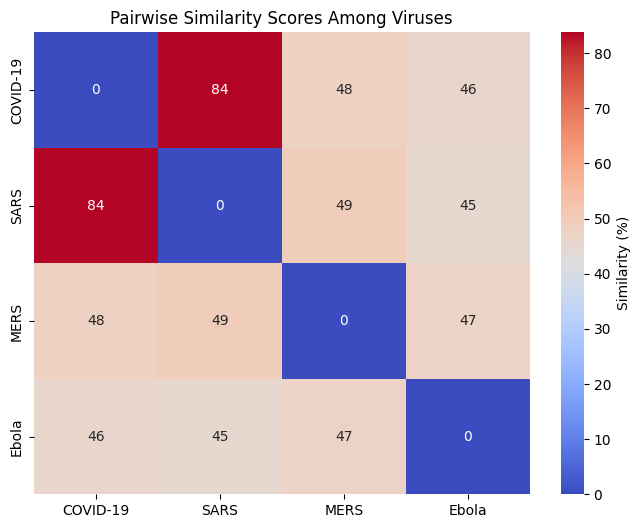

In [ ]:
# Visualization of Similarity Scores
similarity_matrix = pd.DataFrame(np.zeros((len(genomes), len(genomes))), index=genomes.keys(), columns=genomes.keys())
for (name1, name2), score in similarity_scores.items():
    similarity_matrix.loc[name1, name2] = score
    similarity_matrix.loc[name2, name1] = score

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm", cbar_kws={'label': 'Similarity (%)'})
plt.title("Pairwise Similarity Scores Among Viruses")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


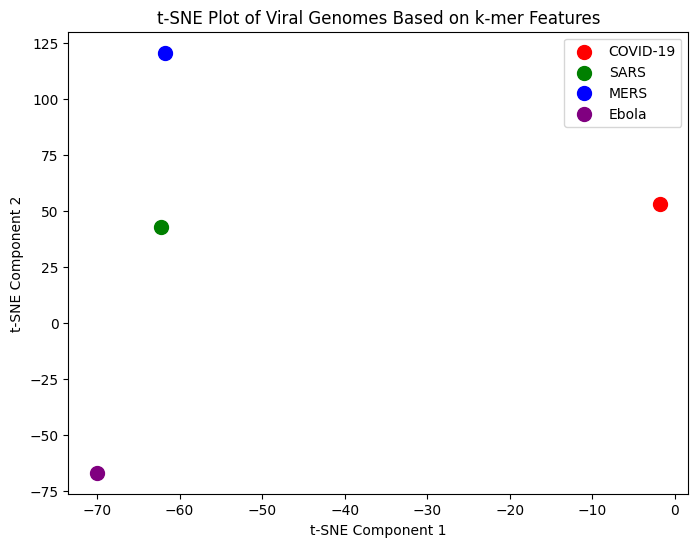


Cluster assignments based on t-SNE and K-means clustering:
COVID-19 assigned to cluster 0
SARS assigned to cluster 0
MERS assigned to cluster 0
Ebola assigned to cluster 1


In [ ]:
# Step 3: AI-Driven Analysis - Convert Sequences to k-mer Embeddings and Cluster
def get_kmers(sequence, k=4):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Transform sequences to k-mer space
k = 4
corpus = [" ".join(get_kmers(str(genome.seq[:1000]), k)) for genome in genomes.values()]
vectorizer = CountVectorizer().fit(corpus)
X = vectorizer.transform(corpus).toarray()

# Dimensionality Reduction using t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=2, n_iter=300)
X_tsne = tsne.fit_transform(X)

# Clustering the viruses based on k-mer profiles
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(X_tsne)

# Visualization of clustering with color classification
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue', 'purple']  # Different colors for each virus
for i, name in enumerate(genomes.keys()):
    plt.scatter(X_tsne[i, 0], X_tsne[i, 1], label=name, color=colors[i], s=100)
plt.title("t-SNE Plot of Viral Genomes Based on k-mer Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

# Summary of Clustering and Visual Exploration
print("\nCluster assignments based on t-SNE and K-means clustering:")
for i, name in enumerate(genomes.keys()):
    print(f"{name} assigned to cluster {clusters[i]}")


Nucleotide Frequencies (A, T, C, G) for each virus:
COVID-19 nucleotide frequencies: {'A': 25.1, 'T': 27.800000000000004, 'C': 22.5, 'G': 24.6}
SARS nucleotide frequencies: {'A': 25.5, 'T': 25.8, 'C': 23.799999999999997, 'G': 24.9}
MERS nucleotide frequencies: {'A': 24.4, 'T': 28.299999999999997, 'C': 22.7, 'G': 24.6}
Ebola nucleotide frequencies: {'A': 31.8, 'T': 26.700000000000003, 'C': 19.2, 'G': 22.3}


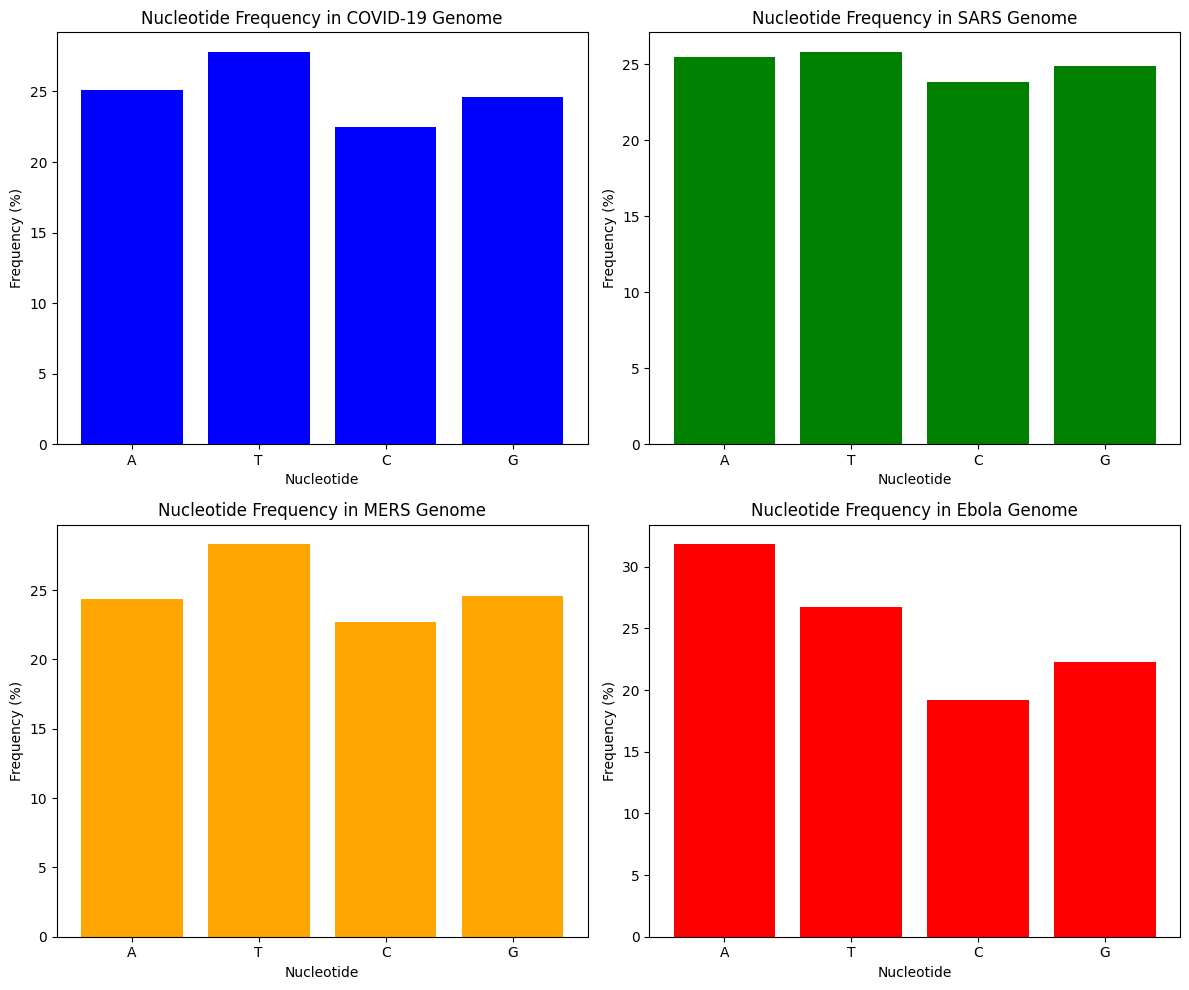

In [ ]:
# Step 4: Calculate and Display Nucleotide Frequency for Each Genome with colors
print("\nNucleotide Frequencies (A, T, C, G) for each virus:")

# Define the color for each virus
colors = {'COVID-19': 'blue', 'SARS': 'green', 'MERS': 'orange', 'Ebola': 'red'}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid for 4 plots
axes = axes.flatten()  # Flatten to make indexing easier

for i, (name, genome) in enumerate(genomes.items()):
    freq = calculate_nucleotide_frequency(str(genome.seq[:1000]))  # Taking first 1000 bases for frequency analysis
    print(f"{name} nucleotide frequencies: {freq}")

    # Plotting nucleotide frequencies with color classification
    axes[i].bar(freq.keys(), freq.values(), color=colors[name])
    axes[i].set_title(f"Nucleotide Frequency in {name} Genome")
    axes[i].set_xlabel("Nucleotide")
    axes[i].set_ylabel("Frequency (%)")

# Adjust layout
plt.tight_layout()
plt.show()



Trinucleotide Frequencies for each virus:
COVID-19 trinucleotide frequencies (top 10):
{'CTT': 3.006012024048096, 'AAC': 2.905811623246493, 'ACT': 2.6052104208416833, 'GTG': 2.6052104208416833, 'TGG': 2.50501002004008, 'AAA': 2.2044088176352705, 'GGT': 2.2044088176352705, 'TGT': 2.2044088176352705, 'TAA': 2.1042084168336674, 'TTA': 2.004008016032064}
SARS trinucleotide frequencies (top 10):
{'GTG': 2.6052104208416833, 'AAA': 2.50501002004008, 'GCA': 2.404809619238477, 'AAC': 2.3046092184368736, 'TCT': 2.2044088176352705, 'CTG': 2.2044088176352705, 'ACT': 2.2044088176352705, 'GGT': 2.1042084168336674, 'TCG': 2.1042084168336674, 'TGT': 2.1042084168336674}
MERS trinucleotide frequencies (top 10):
{'TGG': 3.5070140280561124, 'GTG': 2.905811623246493, 'TTG': 2.6052104208416833, 'AAA': 2.6052104208416833, 'ATG': 2.50501002004008, 'GGC': 2.3046092184368736, 'TGT': 2.3046092184368736, 'TGA': 2.2044088176352705, 'TCT': 2.1042084168336674, 'CTT': 2.004008016032064}
Ebola trinucleotide frequenci

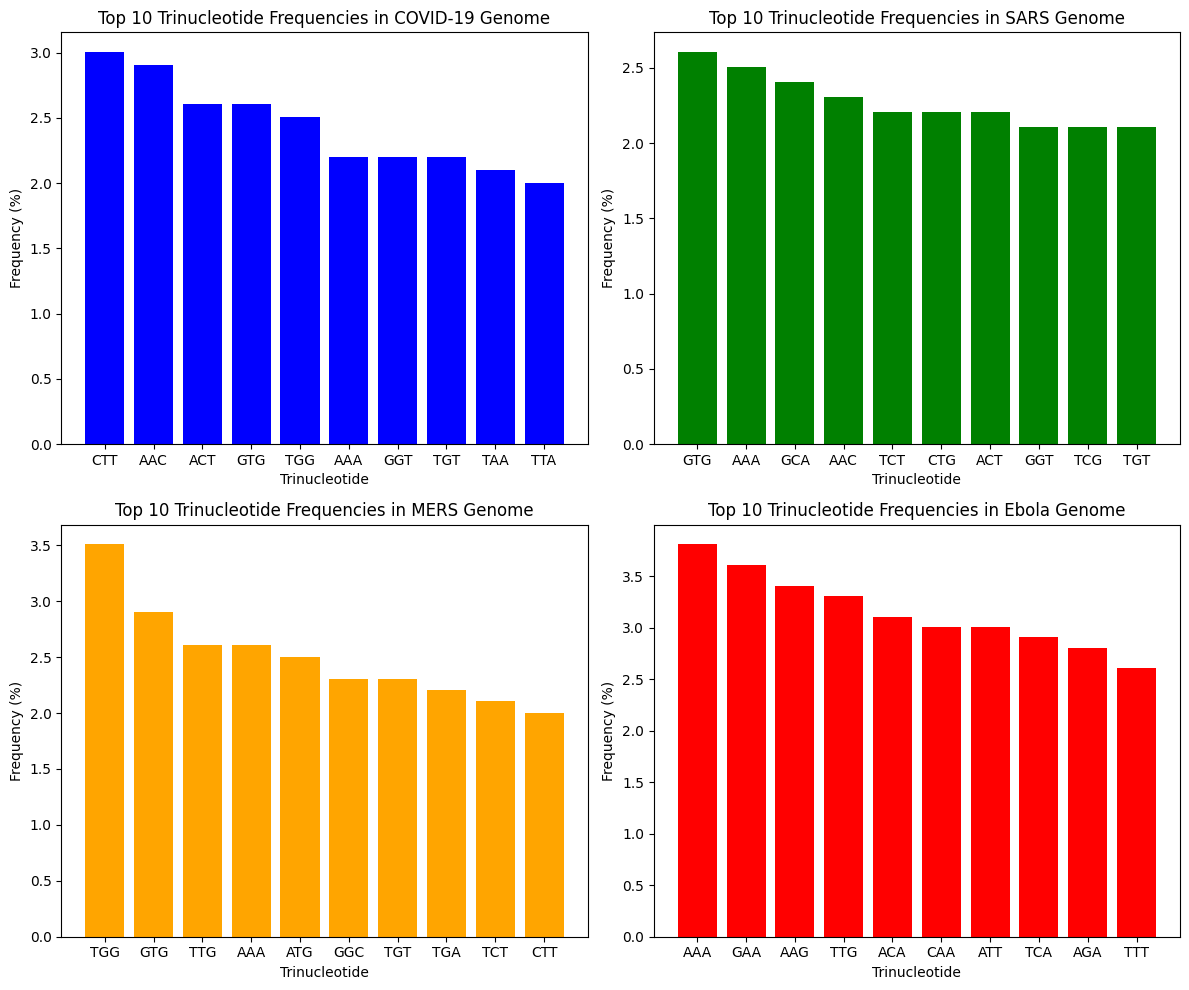

In [ ]:
# Step 5: Calculate and Display Trinucleotide Frequencies for Each Genome with colors
print("\nTrinucleotide Frequencies for each virus:")

# Define the color for each virus
colors = {'COVID-19': 'blue', 'SARS': 'green', 'MERS': 'orange', 'Ebola': 'red'}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid for 4 plots
axes = axes.flatten()  # Flatten to make indexing easier

for i, (name, genome) in enumerate(genomes.items()):
    trinucleotide_freq = calculate_trinucleotide_frequency(str(genome.seq[:1000]))  # Taking first 1000 bases for trinucleotide analysis
    print(f"{name} trinucleotide frequencies (top 10):")

    # Display top 10 most common trinucleotides
    sorted_trinucleotides = dict(sorted(trinucleotide_freq.items(), key=lambda item: item[1], reverse=True)[:10])
    print(sorted_trinucleotides)

    # Plotting trinucleotide frequencies with color classification
    axes[i].bar(sorted_trinucleotides.keys(), sorted_trinucleotides.values(), color=colors[name])
    axes[i].set_title(f"Top 10 Trinucleotide Frequencies in {name} Genome")
    axes[i].set_xlabel("Trinucleotide")
    axes[i].set_ylabel("Frequency (%)")

# Adjust layout
plt.tight_layout()
plt.show()



Amino Acid Composition for each virus:
COVID-19 amino acid composition (top 10):
{'R': 12.012012012012011, 'S': 10.81081081081081, '*': 10.21021021021021, 'T': 8.708708708708707, 'L': 8.408408408408409, 'C': 5.7057057057057055, 'G': 5.405405405405405, 'P': 4.504504504504505, 'W': 4.504504504504505, 'V': 3.903903903903904}
SARS amino acid composition (top 10):
{'L': 10.21021021021021, 'G': 9.00900900900901, 'V': 9.00900900900901, 'R': 6.906906906906906, 'S': 6.906906906906906, 'E': 6.606606606606606, 'K': 5.405405405405405, 'T': 5.105105105105105, 'A': 5.105105105105105, 'D': 5.105105105105105}
MERS amino acid composition (top 10):
{'L': 15.315315315315313, 'S': 10.51051051051051, 'V': 7.5075075075075075, 'T': 7.207207207207207, 'A': 6.006006006006006, 'R': 5.7057057057057055, 'I': 5.7057057057057055, 'C': 4.504504504504505, 'M': 4.504504504504505, 'K': 3.903903903903904}
Ebola amino acid composition (top 10):
{'S': 15.015015015015015, 'L': 9.00900900900901, '*': 8.708708708708707, 'R'

/usr/local/lib/python3.10/dist-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


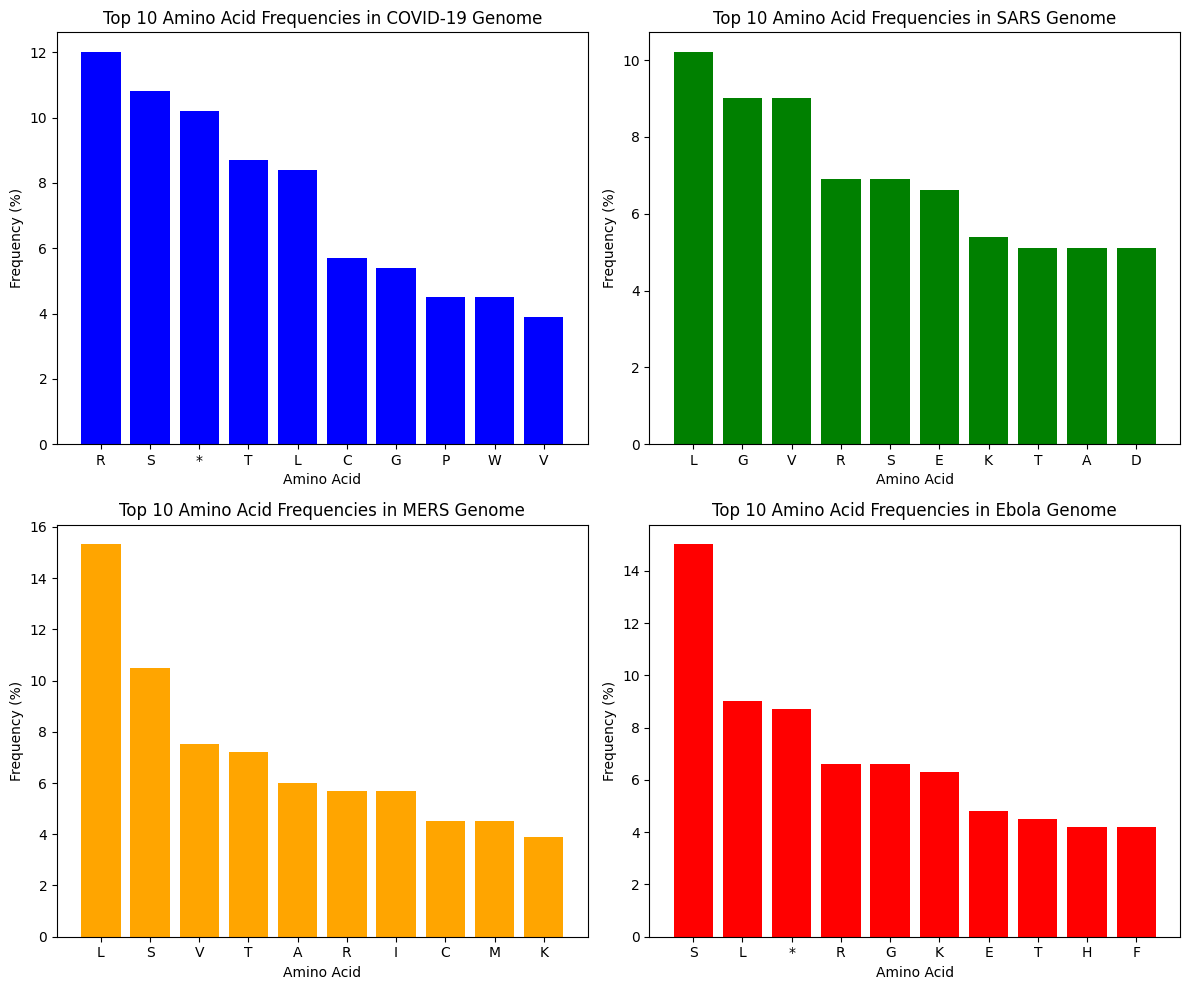

In [ ]:
# Step 6: Calculate and Display Amino Acid Composition for Each Genome with colors
print("\nAmino Acid Composition for each virus:")

# Define the color for each virus
colors = {'COVID-19': 'blue', 'SARS': 'green', 'MERS': 'orange', 'Ebola': 'red'}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid for 4 plots
axes = axes.flatten()  # Flatten to make indexing easier

for i, (name, genome) in enumerate(genomes.items()):
    aa_composition = calculate_amino_acid_composition(genome.seq[:1000])  # Taking first 1000 bases for translation
    print(f"{name} amino acid composition (top 10):")

    # Display top 10 most common amino acids
    sorted_aa_composition = dict(sorted(aa_composition.items(), key=lambda item: item[1], reverse=True)[:10])
    print(sorted_aa_composition)

    # Plotting amino acid frequencies with color classification
    axes[i].bar(sorted_aa_composition.keys(), sorted_aa_composition.values(), color=colors[name])
    axes[i].set_title(f"Top 10 Amino Acid Frequencies in {name} Genome")
    axes[i].set_xlabel("Amino Acid")
    axes[i].set_ylabel("Frequency (%)")

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Step 7: Display Sequence Alignments and Identity
print("\nSequence Alignment and Identity between different viruses:")

# Loop over all pairwise alignments and calculate identity
for (name1, name2), alignment in alignment_sequences.items():
    # Format alignment for better readability
    aligned_seq1 = alignment[0]
    aligned_seq2 = alignment[1]
    identity = sum(a == b for a, b in zip(aligned_seq1, aligned_seq2)) / len(aligned_seq1) * 100

    # Print sequence alignment and identity in a well-organized format
    print(f"\n{'='*50}")
    print(f"Alignment between {name1} and {name2}:")
    print(f"{'-'*50}")

    # Display the full formatted alignment
    print(f"\nFull Alignment:\n")
    print(pairwise2.format_alignment(*alignment))  # Display the full alignment

    # Show first 100 bases for each sequence with proper alignment (gaps included)
    print(f"Sequence from {name1} (first 100 bases):")
    aligned_seq1_trimmed = aligned_seq1[:100]  # Limit to 100 bases for clarity
    print(aligned_seq1_trimmed)

    print(f"Sequence from {name2} (first 100 bases):")
    aligned_seq2_trimmed = aligned_seq2[:100]  # Limit to 100 bases for clarity
    print(aligned_seq2_trimmed)

    # Display identity percentage
    print(f"\nIdentity between {name1} and {name2}: {identity:.2f}%")
    print(f"{'='*50}\n")



Sequence Alignment and Identity between different viruses:

Alignment between COVID-19 and SARS:
--------------------------------------------------

Full Alignment:

ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAA--TTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACC--TCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAAC